In [1]:
import xarray as xr
import matplotlib.pyplot as plt

## GRACE derived transport

In [2]:
ds_80_sec1_lower=xr.open_dataset('./data/arctic_80.25_sec1_tran_1500_3000.nc')
ds_80_sec2_lower=xr.open_dataset('./data/arctic_80.25_sec2_tran_1500_3500.nc')
ds_80_upper=xr.open_dataset('./data/arctic_80.25_tran_0_1500.nc')
ds_80=ds_80_sec1_lower+ds_80_sec2_lower+ds_80_upper

In [3]:
ds_75_sec1_upper=xr.open_dataset('./data/arctic_75.25_sec1_tran_0_1000.nc')
ds_75_sec2_upper=xr.open_dataset('./data/arctic_75.25_sec2_tran_0_600.nc')
ds_75_lower=xr.open_dataset('./data/arctic_75.25_tran_1000_4000.nc')
ds_75=ds_75_sec1_upper+ds_75_sec2_upper+ds_75_lower

In [4]:
ds_73=xr.open_dataset('./data/arctic_73.75_tran_0_3700.nc')

## Mooring observed transport 

In [5]:
import pandas as pd
import numpy as np
import datetime
from regression import regress
from time_convert import time_convert

# read data
f = open("./data/bering_strait_mooring.txt")
skiprow=39
i=0
lines=[]
for line in f :
    if i > skiprow :
        elements=line.split()
        ii=0
        for element in elements:
            if element == 'NaN':
                elements[ii]=np.nan
            else :
                elements[ii]=np.float(element)
            ii+=1
        lines.append(elements)
    elif i == skiprow:
        header=line.split()
    i+=1
    
# saved in pandas dataframe
df=pd.DataFrame(lines,columns=header[1:])
df['Year']=pd.Series(df['Year'],dtype=int)
df['Month']=pd.Series(df['Month'],dtype=int)

# create timestamp
df['Yearmonth']=df['Year']*100+df['Month']
func= lambda x : datetime.datetime(x/100,x-x/100*100,15)
df['time']=df['Yearmonth'].map(func)

# set timestamp as index
df.set_index('time',inplace=True)

# export pandas dataframe as xarray dataset
ds_bs=df.to_xarray()
ds_bs_dropna=ds_bs.dropna('time')

# perform regression
ts=time_convert(ds_bs_dropna.time)
yeardate=ts.tarray_month2year()
reg=regress(axis=yeardate)

dict1=reg.multivar_regress(ds_bs_dropna.Mean1.values,predef_var='semisea_sea_lin')
list_variates=dict1['list_variates']
betas=dict1['beta']
linmodel=betas[0]*list_variates[0]+betas[1]*list_variates[1]
model=dict1['model']
res=ds_bs_dropna.Mean1.values-model
reslin=ds_bs_dropna.Mean1.values-linmodel
Mean1_res=xr.DataArray(res, coords={"time":ds_bs_dropna.time},dims="time")
Mean1_reslin=xr.DataArray(reslin, coords={"time":ds_bs_dropna.time},dims="time")
ds_bs['Mean1_res']=Mean1_res
ds_bs['Mean1_reslin']=Mean1_reslin

dict1=reg.multivar_regress(ds_bs_dropna.Mean2.values,predef_var='semisea_sea_lin')
list_variates=dict1['list_variates']
betas=dict1['beta']
linmodel=betas[0]*list_variates[0]+betas[1]*list_variates[1]
model=dict1['model']
res=ds_bs_dropna.Mean2.values-model
reslin=ds_bs_dropna.Mean2.values-linmodel
Mean2_res=xr.DataArray(res, coords={"time":ds_bs_dropna.time},dims="time")
Mean2_reslin=xr.DataArray(reslin, coords={"time":ds_bs_dropna.time},dims="time")
ds_bs['Mean2_res']=Mean2_res
ds_bs['Mean2_reslin']=Mean2_reslin


In [6]:
ds_bs.Mean2.sel(time=datetime.datetime(2015,1,15))

<xarray.DataArray 'Mean2' ()>
array(1.05)
Coordinates:
    time     datetime64[ns] 2015-01-15

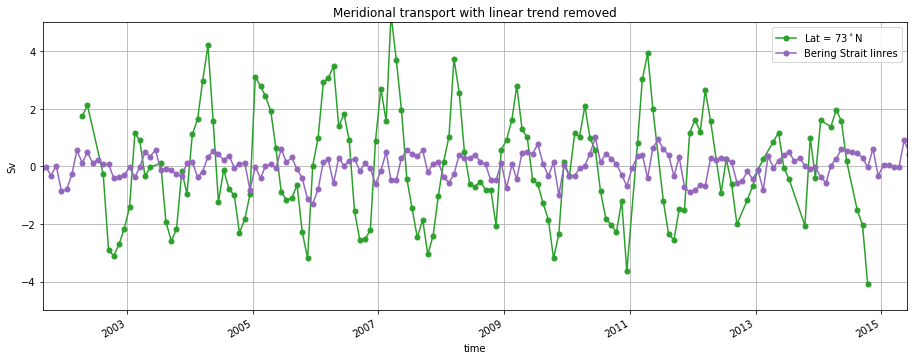

In [7]:
fig=plt.figure(figsize=[6,2])
ax1=fig.add_axes([0,0,2,2])
# ds_80.meridN_res.plot(ax=ax1, color='C0', marker='o',markersize=5,label='Lat = 80$^\circ$N')
# ds_75.meridN_res.plot(ax=ax1, color='C1', marker='o',markersize=5,label='Lat = 75$^\circ$N')
# ds_73.meridN_res.plot(ax=ax1, color='C2', marker='o',markersize=5,label='Lat = 73$^\circ$N')
ds_73.meridN_reslin.plot(ax=ax1, color='C2', marker='o',markersize=5,label='Lat = 73$^\circ$N')
# ds_bs.Mean1.plot(ax=ax1, color='C3', marker='o',markersize=5,label='Bering Strait')
ds_bs.Mean1_reslin.plot(ax=ax1, color='C4', marker='o',markersize=5,label='Bering Strait linres')
# ds_bs.Mean1_res.plot(ax=ax1, color='C4', marker='o',markersize=5,label='Bering Strait res')
ax1.set_ylabel('Sv')
# ax1.set_ylim(bottom=-5,top=6)
ax1.set_ylim(bottom=-5,top=5)
ax1.grid()
ax1.legend()
ax1.set_title("Meridional transport with linear trend removed")


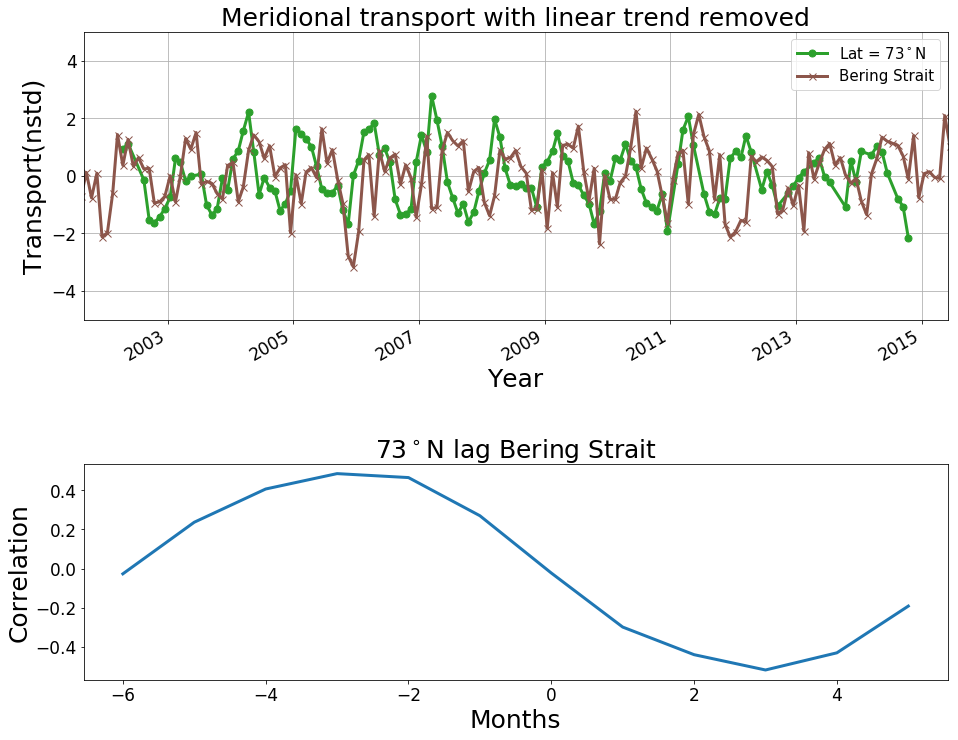

In [48]:
# calculate the normalizd variation so the output is number of std
ds_73['meridN_reslin_norm']=ds_73.meridN_reslin/np.std(ds_73.meridN_reslin.values)
ds_bs['Mean1_reslin_norm']=ds_bs.Mean1_reslin/np.nanstd(ds_bs.Mean1_reslin.values)
ds_bs['Mean2_reslin_norm']=ds_bs.Mean2_reslin/np.nanstd(ds_bs.Mean2_reslin.values)

fig=plt.figure(figsize=[6,2])
ax1=fig.add_axes([0,0,2,2])
# ds_80.meridN_res.plot(ax=ax1, color='C0', marker='o',markersize=5,label='Lat = 80$^\circ$N')
# ds_75.meridN_res.plot(ax=ax1, color='C1', marker='o',markersize=5,label='Lat = 75$^\circ$N')
# ds_73.meridN_res.plot(ax=ax1, color='C2', marker='o',markersize=5,label='Lat = 73$^\circ$N')
ds_73.meridN_reslin_norm.plot(ax=ax1, color='C2', marker='o',markersize=7,label='Lat = 73$^\circ$N',linewidth=3)
# ds_bs.Mean1.plot(ax=ax1, color='C3', marker='o',markersize=5,label='Bering Strait')
# ds_bs.Mean1_reslin_norm.plot(ax=ax1, color='C4', marker='o',markersize=7,label='Bering Strait linres')
ds_bs.Mean2_reslin_norm.plot(ax=ax1, color='C5', marker='x',markersize=7,label='Bering Strait',linewidth=3)
# ds_bs.Mean1_res.plot(ax=ax1, color='C4', marker='o',markersize=5,label='Bering Strait res')
ax1.set_ylabel('nstd',fontdict={'size':25})
# ax1.set_ylim(bottom=-5,top=6)
ax1.set_ylim(bottom=-5,top=5)
ax1.grid()
ax1.legend(fontsize=15)
ax1.set_title("Meridional transport with linear trend removed",fontdict={'size':25})
ax1.set_ylabel('Transport(nstd)',fontdict={'size':25})
ax1.set_xlabel('Year',fontdict={'size':25})
ax1.tick_params(labelsize=17)


from scipy.stats import pearsonr
overlapt=ds_73.meridN_reslin_norm.time.values
leadlag=np.zeros([12,2])

for i in range(12):
    r,pval=pearsonr(ds_bs.Mean2_reslin_norm.sel(time=overlapt[6:-6])
                ,ds_73.meridN_reslin_norm.sel(time=overlapt[i:-(12-i)]))
    leadlag[i,0]=r
    leadlag[i,1]=pval

ax2=fig.add_axes([0,-2.5,2,1.5])
ax2.plot(range(-6,6,1), leadlag[:,0],linewidth=3)
ax2.set_title('73$^\circ$N lag Bering Strait',fontdict={'size':25})
ax2.set_ylabel('Correlation',fontdict={'size':25})
ax2.set_xlabel('Months',fontdict={'size':25})
ax2.tick_params(labelsize=17)

# export the figure
fig.savefig('./figures/arctic_73.75_tran_bering_comp.pdf', dpi=300, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=False, bbox_inches="tight", pad_inches=None,
        frameon=None)

# Original time series 
* Comparison between 73.75 and 75.25. 
* Focus on the seasonal variabilities. 
* This seasonal signal should be compare with the recent Arctic - Pacific flux study.

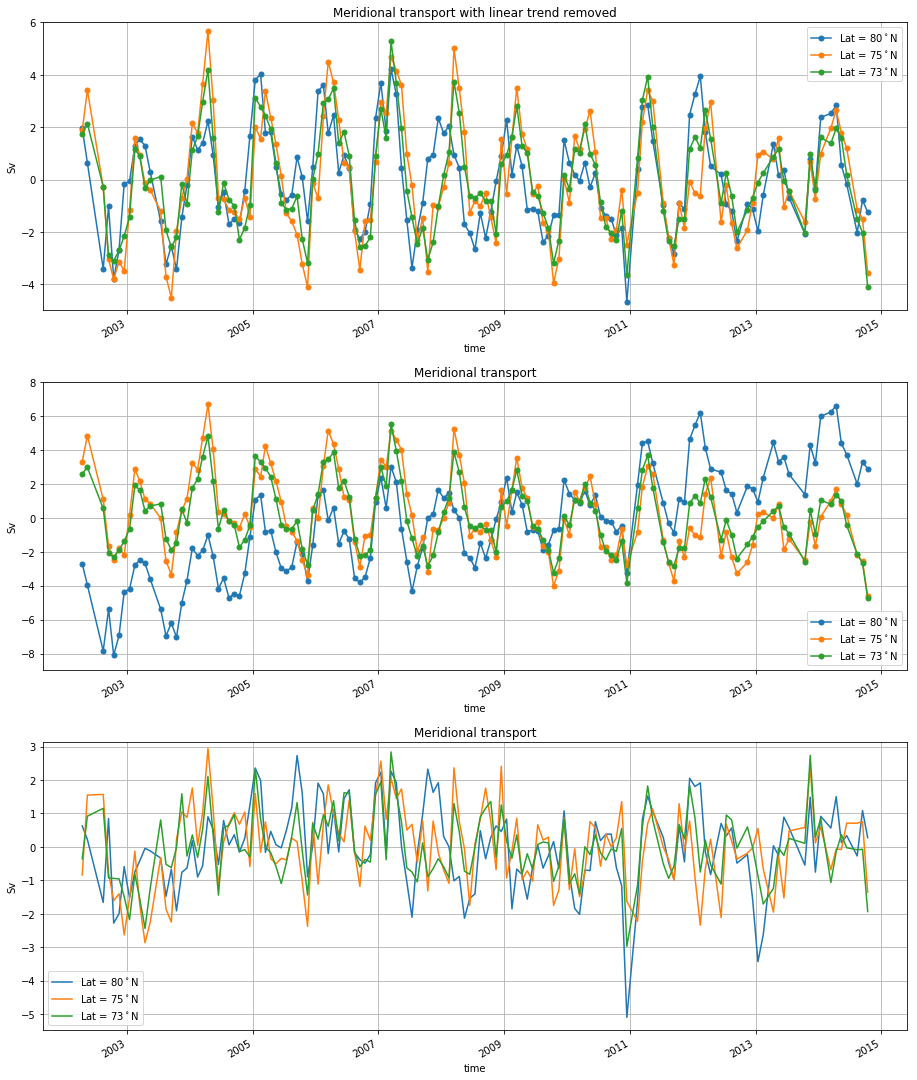

In [9]:
fig=plt.figure(figsize=[6,2])
ax1=fig.add_axes([0,0,2,2])
ds_80.meridN_reslin.plot(ax=ax1, color='C0', marker='o',markersize=5,label='Lat = 80$^\circ$N')
ds_75.meridN_reslin.plot(ax=ax1, color='C1', marker='o',markersize=5,label='Lat = 75$^\circ$N')
ds_73.meridN_reslin.plot(ax=ax1, color='C2', marker='o',markersize=5,label='Lat = 73$^\circ$N')
ax1.set_ylabel('Sv')
ax1.set_ylim(bottom=-5,top=6)
ax1.grid()
ax1.legend()
ax1.set_title("Meridional transport with linear trend removed")

ax2=fig.add_axes([0,-2.5,2,2])
ds_80.meridN.plot(ax=ax2, color='C0', marker='o',markersize=5,label='Lat = 80$^\circ$N')
ds_75.meridN.plot(ax=ax2, color='C1', marker='o',markersize=5,label='Lat = 75$^\circ$N')
ds_73.meridN.plot(ax=ax2, color='C2', marker='o',markersize=5,label='Lat = 73$^\circ$N')
ax2.set_ylabel('Sv')
ax2.set_ylim(bottom=-9,top=8)
ax2.grid()
ax2.legend()
ax2.set_title("Meridional transport")

ax3=fig.add_axes([0,-5,2,2])
ds_80.meridN_res.plot(ax=ax3, color='C0', marker='',markersize=5,label='Lat = 80$^\circ$N')
ds_75.meridN_res.plot(ax=ax3, color='C1', marker='',markersize=5,label='Lat = 75$^\circ$N')
ds_73.meridN_res.plot(ax=ax3, color='C2', marker='',markersize=5,label='Lat = 73$^\circ$N')
ax3.set_ylabel('Sv')
# ax3.set_ylim(bottom=-5,top=6)
ax3.grid()
ax3.legend()
ax3.set_title("Meridional transport")


# With only regression model removed 

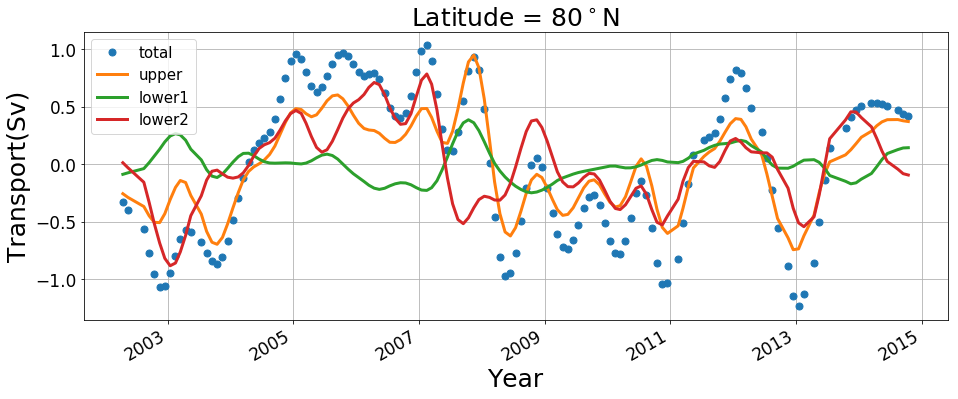

In [30]:
tottran_80=ds_80_upper.meridN_sm_res+ds_80_sec1_lower.meridN_sm_res+ds_80_sec2_lower.meridN_sm_res
fig=plt.figure(figsize=[6,2])
ax1=fig.add_axes([0,0,2,2])
tottran_80.plot(ax=ax1, marker='o', linestyle='none',markersize=7,label='total')
ds_80_upper.meridN_sm_res.plot(ax=ax1,label='upper',linewidth=3)
ds_80_sec1_lower.meridN_sm_res.plot(ax=ax1,label='lower1',linewidth=3)
ds_80_sec2_lower.meridN_sm_res.plot(ax=ax1,label='lower2',linewidth=3)

ax1.grid()
ax1.legend(fontsize=15)

ax1.set_ylabel('Transport(Sv)',fontdict={'size':25})
ax1.set_xlabel('Year',fontdict={'size':25})
ax1.tick_params(labelsize=17)
ax1.set_title('Latitude = 80$^\circ$N',fontdict={'size':25})

# export the figure
fig.savefig('./figures/arctic_80.25_tran_sm_res_comp.pdf', dpi=300, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=False, bbox_inches="tight", pad_inches=None,
        frameon=None)

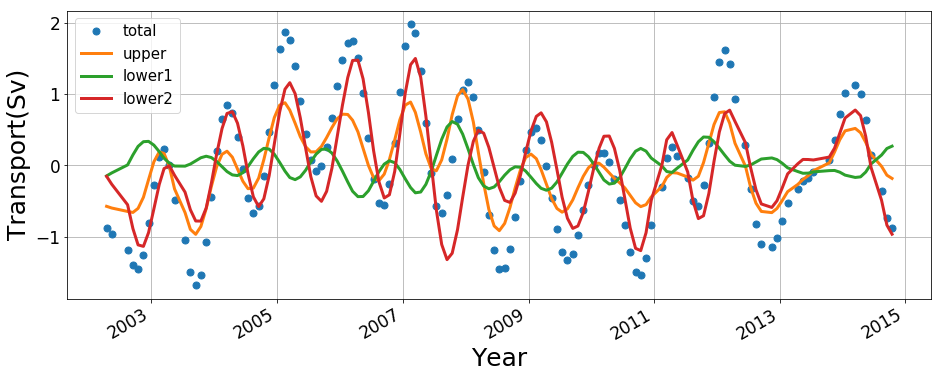

In [32]:
tottran_80=ds_80_upper.meridN_sm_reslin+ds_80_sec1_lower.meridN_sm_reslin+ds_80_sec2_lower.meridN_sm_reslin
fig=plt.figure(figsize=[6,2])
ax1=fig.add_axes([0,0,2,2])
tottran_80.plot(ax=ax1, marker='o', linestyle='none',markersize=7,label='total')
ds_80_upper.meridN_sm_reslin.plot(ax=ax1,label='upper',linewidth=3)
ds_80_sec1_lower.meridN_sm_reslin.plot(ax=ax1,label='lower1',linewidth=3)
ds_80_sec2_lower.meridN_sm_reslin.plot(ax=ax1,label='lower2',linewidth=3)

ax1.grid()
ax1.legend(fontsize=15)

ax1.set_ylabel('Transport(Sv)',fontdict={'size':25})
ax1.set_xlabel('Year',fontdict={'size':25})
ax1.tick_params(labelsize=17)
# ax1.set_title('Latitude = 80$^\circ$N',fontdict={'size':25})
ax1.set_title("")

# export the figure
fig.savefig('./figures/arctic_80.25_tran_sm_reslin_comp.pdf', dpi=300, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=False, bbox_inches="tight", pad_inches=None,
        frameon=None)

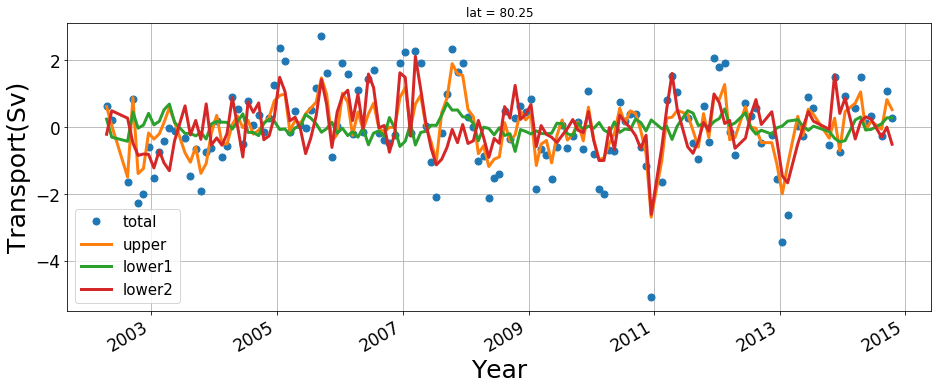

In [27]:
tottran_80=ds_80_upper.meridN_res+ds_80_sec1_lower.meridN_res+ds_80_sec2_lower.meridN_res
fig=plt.figure(figsize=[6,2])
ax1=fig.add_axes([0,0,2,2])
tottran_80.plot(ax=ax1, marker='o', linestyle='none',markersize=7,label='total')
ds_80_upper.meridN_res.plot(ax=ax1,label='upper',linewidth=3)
ds_80_sec1_lower.meridN_res.plot(ax=ax1,label='lower1',linewidth=3)
ds_80_sec2_lower.meridN_res.plot(ax=ax1,label='lower2',linewidth=3)

ax1.grid()
ax1.legend(fontsize=15)

ax1.set_ylabel('Transport(Sv)',fontdict={'size':25})
ax1.set_xlabel('Year',fontdict={'size':25})
ax1.tick_params(labelsize=17)

# export the figure
fig.savefig('./figures/arctic_80.25_tran_comp.pdf', dpi=300, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=False, bbox_inches="tight", pad_inches=None,
        frameon=None)

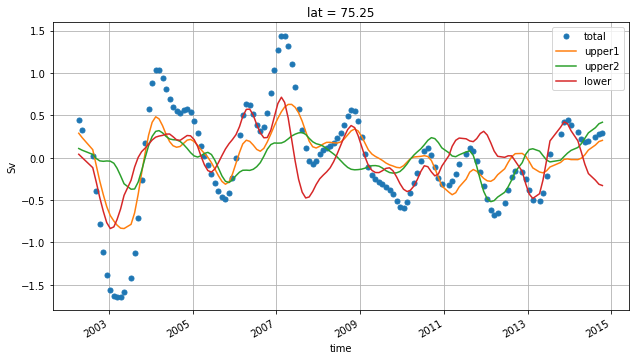

In [11]:
tottran_75=ds_75_sec1_upper.meridN_sm_res+ds_75_sec2_upper.meridN_sm_res+ds_75_lower.meridN_sm_res
fig=plt.figure(figsize=[4,2])
ax1=fig.add_axes([0,0,2,2])
tottran_75.plot(ax=ax1, marker='o', linestyle='none',markersize=5,label='total')
ds_75_sec1_upper.meridN_sm_res.plot(ax=ax1,label='upper1')
ds_75_sec2_upper.meridN_sm_res.plot(ax=ax1,label='upper2')
ds_75_lower.meridN_sm_res.plot(ax=ax1,label='lower')
ax1.set_ylabel('Sv')
ax1.grid()
ax1.legend()

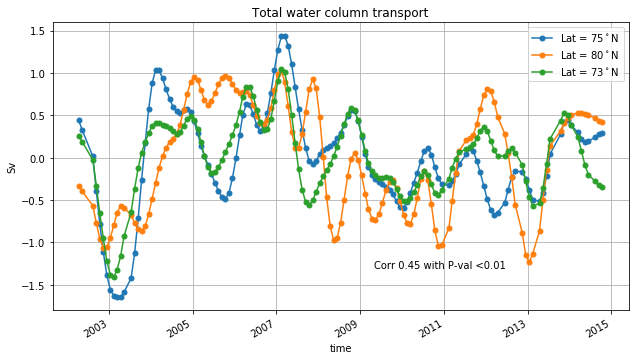

In [12]:
import numpy as np
from scipy.stats.stats import pearsonr
import datetime

r,pval=pearsonr(tottran_75,tottran_80)
fig=plt.figure(figsize=[4,2])
ax1=fig.add_axes([0,0,2,2])
tottran_75.plot(ax=ax1, marker='o', linestyle='solid',markersize=5,label='Lat = 75$^\circ$N')
tottran_80.plot(ax=ax1, marker='o', linestyle='solid',markersize=5,label='Lat = 80$^\circ$N')
ds_73.meridN_sm_res.plot(ax=ax1, marker='o', linestyle='solid',markersize=5,label='Lat = 73$^\circ$N')

ax1.set_ylabel('Sv')
ax1.set_title("Total water column transport")
ax1.grid()
ax1.legend()
ax1.text(datetime.datetime(2009,5,1),-1.3,"Corr %0.2f with P-val <0.01"%(r))

# With only linear model removed 

In [13]:
tottran_80_sea=ds_80_upper.meridN_sm_reslin+ds_80_sec1_lower.meridN_sm_reslin+ds_80_sec2_lower.meridN_sm_reslin
tottran_75_sea=ds_75_sec1_upper.meridN_sm_reslin+ds_75_sec2_upper.meridN_sm_reslin+ds_75_lower.meridN_sm_reslin

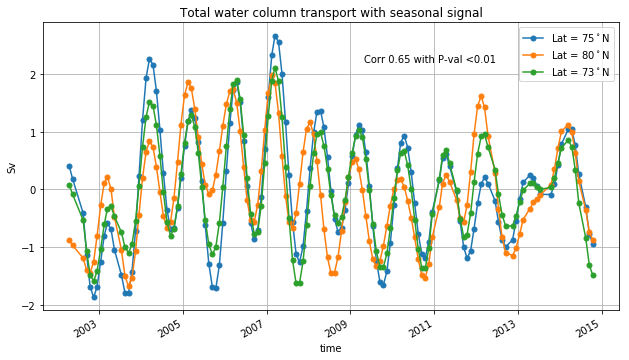

In [14]:
r,pval=pearsonr(tottran_75_sea,tottran_80_sea)
fig=plt.figure(figsize=[4,2])
ax1=fig.add_axes([0,0,2,2])
tottran_75_sea.plot(ax=ax1, marker='o', linestyle='solid',markersize=5,label='Lat = 75$^\circ$N')
tottran_80_sea.plot(ax=ax1, marker='o', linestyle='solid',markersize=5,label='Lat = 80$^\circ$N')
ds_73.meridN_sm_reslin.plot(ax=ax1, marker='o', linestyle='solid',markersize=5,label='Lat = 73$^\circ$N')
ax1.set_ylabel('Sv')
ax1.set_title("Total water column transport with seasonal signal")
ax1.grid()
ax1.legend()
ax1.text(datetime.datetime(2009,5,1),2.2,"Corr %0.2f with P-val <0.01"%(r))

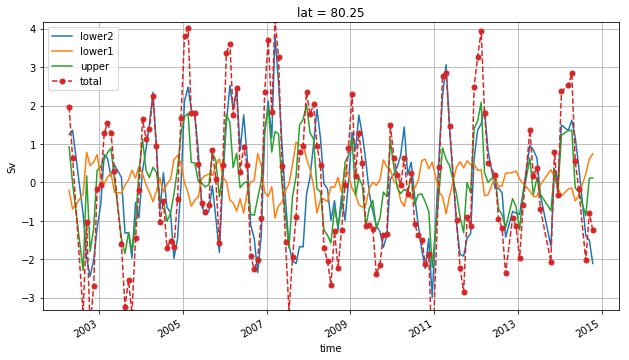

In [15]:
fig=plt.figure(figsize=[4,2])
ax1=fig.add_axes([0,0,2,2])
# tottran_80.plot(ax=ax1, marker='o', linestyle='none',markersize=5,label='total')
# 
ds_80_sec2_lower.meridN_reslin.plot(ax=ax1,label='lower2')
ds_80_sec1_lower.meridN_reslin.plot(ax=ax1,label='lower1')
ds_80_upper.meridN_reslin.plot(ax=ax1,label='upper')
tot=ds_80_sec2_lower.meridN_reslin+ds_80_sec1_lower.meridN_reslin+ds_80_upper.meridN_reslin
tot.plot(ax=ax1, marker='o', linestyle='dashed',markersize=5,label='total')

ax1.set_ylabel('Sv')
ax1.grid()
ax1.legend()